### Perturbed AMIP SST ACE2 evaluation experiments

Evaluates the ACE2-SHiELD and ACE2-ERA5 checkpoints with uniform perturbations to the AMIP historical SSTs, i.e., "AMIP-p4K" type experiments.

For SHiELD, we can compare ACE2's behavior against +2K and +4K runs. 

In [1]:
import xarray as xr
import numpy as np
from dask.diagnostics import ProgressBar
from dask import config as daskconfig
from cartopy import crs as ccrs
from matplotlib import pyplot as plt
from string import ascii_lowercase
from utils import wandb_to_beaker_result, beaker_to_xarray, savefig, FONTSIZE
from typing import Sequence
from constants import PERTURBED_SSTS

/home/brianhenn/miniconda3/envs/fme/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.0 is exactly one major version older than the runtime version 6.30.2 at beaker.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


In [2]:
PLOT_VARS = ['TMP2m']
EVALUATION_PERIOD = slice('1990-01-01', '2020-12-31')

SHIELD_REFERENCE_ZARR = 'gs://vcm-ml-intermediate/2024-07-24-vertically-resolved-c96-1deg-shield-amip-ensemble-dataset/ic_0002.zarr'
SHIELD_P2K_ZARR = 'gs://vcm-ml-intermediate/2025-04-29-c96-1deg-shield-amip-p2k-dataset.zarr'
SHIELD_P4K_ZARR = 'gs://vcm-ml-intermediate/2025-04-29-c96-1deg-shield-amip-p4k-dataset.zarr'
ERA5_REFERENCE_ZARR = 'gs://vcm-ml-intermediate/2024-06-20-era5-1deg-8layer-1940-2022.zarr'

In [3]:
def get_diagnostic_for_all_runs(diagnostic_filename: str, variable_names: Sequence[str]) -> xr.Dataset:
    model_arrays = []
    for model_name, perturbation_ensemble in PERTURBED_SSTS.items():
        print(f"Getting data for {model_name}.")
        peturbation_arrays = []
        for perturbation, wandb_id in perturbation_ensemble.items():
            print(f"Getting data for perturbation {perturbation}K.")
            results_dataset_id = wandb_to_beaker_result(project='ace', id=wandb_id)
            da = beaker_to_xarray(results_dataset_id, diagnostic_filename)[variable_names]
            peturbation_arrays.append(da.expand_dims({'perturbation': [perturbation]}))
        peturbation_arrays = xr.concat(peturbation_arrays, dim='perturbation')
        model_arrays.append(peturbation_arrays.expand_dims({'model_name': [model_name]}))
    return xr.concat(model_arrays, dim='model_name').squeeze()

def weighted_global_mean(da: xr.DataArray, weights: xr.DataArray, dims=('lat', 'lon')) -> xr.DataArray:
    return da.weighted(weights).mean(dim=dims)

In [4]:
# get reference datasets

shield_p0k_ds = xr.open_zarr(
    SHIELD_REFERENCE_ZARR,
    decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
).rename({'grid_xt': 'lon', 'grid_yt': 'lat'})
# these zarr stores below were created with v3 spec and sharding+chunking
# (the original reference zarr was not)
with daskconfig.set({'array.chunk-size': '128MiB'}):
    shield_p2k_ds = xr.open_zarr(
        SHIELD_P2K_ZARR,
        decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        chunks={"time": "auto"},
    ).rename({'grid_xt': 'lon', 'grid_yt': 'lat'})
    shield_p4k_ds = xr.open_zarr(
        SHIELD_P4K_ZARR,
        decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
        chunks={"time": "auto"},
    ).rename({'grid_xt': 'lon', 'grid_yt': 'lat'})

shield_ds = xr.concat(
    [shield_p0k_ds, shield_p2k_ds, shield_p4k_ds],
    dim=xr.DataArray(
        [0.0, 2.0, 4.0],
        dims='perturbation',
        name='perturbation'
    ),
)

era5_ds = (
    xr.open_zarr(
        ERA5_REFERENCE_ZARR,
        decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
    ).rename(
        {'longitude': 'lon', 'latitude': 'lat'}
    ).assign_coords(
        {
            'lon': shield_ds.lon,
            'lat': shield_ds.lat,
        }
    ).expand_dims(
        {'perturbation': [0.0]}
    )
)
        
weights = np.cos(np.deg2rad(shield_ds.lat)).drop_vars('lat')

In [5]:
with ProgressBar():
    shield_time_mean_eval_period = shield_ds[PLOT_VARS].sel(time=EVALUATION_PERIOD).mean('time').compute()
    era5_time_mean_eval_period = era5_ds[PLOT_VARS].sel(time=EVALUATION_PERIOD).mean('time').compute()

[########################################] | 100% Completed | 339.98 s
[########################################] | 100% Completed | 49.90 s


In [6]:
ace2_monthly_means = get_diagnostic_for_all_runs('monthly_mean_predictions.nc', PLOT_VARS + ['counts'])

Getting data for ACE2-SHiELD.
Getting data for perturbation 0.0K.


Output()

Getting data for perturbation 0.5K.


Output()

Getting data for perturbation 1.0K.


Output()

Getting data for perturbation 2.0K.


Output()

Getting data for perturbation 4.0K.


Output()

Getting data for ACE2-ERA5.
Getting data for perturbation 0.0K.


Output()

Getting data for perturbation 0.5K.


Output()

Getting data for perturbation 1.0K.


Output()

Getting data for perturbation 2.0K.


Output()

Getting data for perturbation 4.0K.


Output()

In [7]:
ace2_monthly_means_eval_period = (
    ace2_monthly_means
    .swap_dims({'time': 'valid_time'})
    .drop_vars(['time', 'init_time'])
    .rename({'valid_time': 'time'})
    .sel(time=EVALUATION_PERIOD)
)
ace2_time_mean_eval_period = ace2_monthly_means_eval_period[PLOT_VARS].weighted(ace2_monthly_means_eval_period.counts).mean('time')
ace2_time_mean_eval_period = ace2_time_mean_eval_period.assign_coords({
    'lat': shield_time_mean_eval_period.lat,
    'lon': shield_time_mean_eval_period.lon,
})

In [8]:
time_mean_eval_period = xr.concat(
    [
        ace2_time_mean_eval_period,
        shield_time_mean_eval_period.expand_dims({'model_name': ['SHiELD']}),
        era5_time_mean_eval_period.expand_dims({'model_name': ['ERA5']}),
    ],
    dim='model_name'
)

time_mean_eval_period_response = (
    time_mean_eval_period.drop_sel(perturbation=0.0) - time_mean_eval_period.sel(perturbation=0.0)
).drop_sel(model_name='ERA5')

In [9]:
global_time_mean_eval_period = weighted_global_mean(time_mean_eval_period, weights)

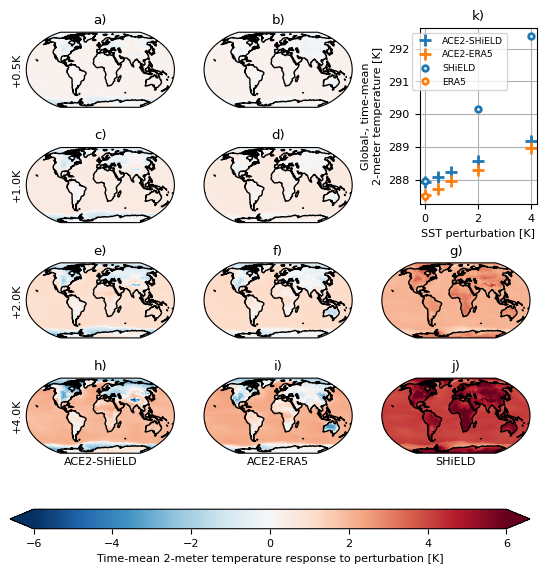

In [10]:
map_plot_kwargs = dict(
    vmin=-6.0,
    vmax=6.0,
    cmap='RdBu_r',
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)

cbar_kwargs = dict(
    orientation='horizontal',
    label='Time-mean 2-meter temperature response to perturbation [K]',
    extend='both'
)

marker_kwargs = dict(ls=' ', mfc='w', markersize=8, mew=2)
markers = ['+', '+', '.', '.']
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = default_colors[:2] + default_colors[:2]

nrows, ncols = time_mean_eval_period_response.sizes['perturbation'], time_mean_eval_period_response.sizes['model_name']
fig, axes = plt.subplots(
    nrows,
    ncols,
    subplot_kw=dict(
        projection=ccrs.Robinson()
    ),
    figsize=(6.5, 6.5),
)
plt.rc('font', size=FONTSIZE)

map_panel_counter = 0
for i, (ax_row, perturbation) in enumerate(zip(axes, time_mean_eval_period_response.perturbation)):
    for j, (ax, model_name) in enumerate(zip(ax_row, time_mean_eval_period_response.model_name)):
        da = time_mean_eval_period_response.TMP2m.sel(perturbation=perturbation, model_name=model_name)
        if np.abs(da).sum() != 0:
            h = da.plot(ax=ax, **map_plot_kwargs)
            ax.coastlines()
            ax.set_title(f"{ascii_lowercase[map_panel_counter]})")
            if i == nrows - 1:
                ax.text(
                    0.5, -0.15, model_name.item(),
                    transform=ax.transAxes, ha='center'
                )
            if j == 0:
                ax.text(
                    -0.1, 0.5, f"+{perturbation:1.1f}K",
                    transform=ax.transAxes, va='center', rotation='vertical'
                )
            map_panel_counter += 1
        else:
            ax.remove()

scatter_ax = fig.add_axes([0.73, 0.60, 0.18, 0.27])
handles = []
for i, model_name in enumerate(global_time_mean_eval_period.model_name):
    da = global_time_mean_eval_period.TMP2m.sel(model_name=model_name)
    handles.append(
        da.plot(ax=scatter_ax, marker=markers[i], color=colors[i], **marker_kwargs)
    )
scatter_ax.set_title(None)
scatter_ax.grid()
scatter_ax.set_xlabel('SST perturbation [K]')
scatter_ax.set_ylabel('Global-, time-mean\n2-meter temperature [K]')
scatter_ax.legend(
    [h[0] for h in handles],
    [name.item() for name in global_time_mean_eval_period.model_name],
    fontsize='small',
    bbox_to_anchor=(-0.1, 1.0),
    loc='upper left',
)
scatter_ax.set_title(f"{ascii_lowercase[map_panel_counter]})")
scatter_ax.set_facecolor('white')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.03])
fig.colorbar(
    h,
    cax=cbar_ax,
    **cbar_kwargs
)
fig.patch.set_alpha(0.0)
savefig(fig, 'supplementary_perturbed_sst_response.png', transparent=False)